This code inputs non-renormalized coarse-grained data (via a Lucy function), calculates the relevant velocity field data and infers velocity and density fields to satisfy continuity.

In [97]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.ndimage import gaussian_filter
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import nnls
from scipy.linalg import null_space

In [98]:
def gaussian_smooth(u,nx,nz,sigma):
    return gaussian_filter(u.reshape((nx,nz)),sigma=sigma).reshape(u.shape)

In [99]:
def phi(X_i,X_j,a2):

    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            #r2 = (X_i[i,0] - X_j[j,0])**2 + (X_i[i,1] - X_j[j,1])**2
            #r = np.sqrt(r2)
            #phimat[i,j] = np.sqrt(1 + a2*r2)
            #phimat[i,j] = r**3*np.log(r**r)
            #phimat[i,j] = r**3
            phimat[i,j] = ((x_i - x_j)**2 + (z_i - z_j)**2)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def nablaphi(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 16*(x_i - x_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(x_i - x_j)**2 + 16*(z_i - z_j)**2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 16*(z_i - z_j)**2
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    return phimat 

def dphidx(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(x_i - x_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def dphidz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]

            phimat[i,j] = 2*(z_i - z_j)*((x_i - x_j)**2 + (z_i - z_j)**2)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 1)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0
    
    return phimat 

def d2phidx2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 14*(x_i - x_j)**2 + 2*(z_i - z_j)**2 + 4*(3*(x_i - x_j)**2 + (z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidz2(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            phimat[i,j] = 2*(x_i - x_j)**2 + 14*(z_i - z_j)**2 + 4*((x_i - x_j)**2 + 3*(z_i - z_j)**2)*np.log((x_i - x_j)**2 + (z_i - z_j)**2)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

def d2phidxdz(X_i,X_j,a2):
    phimat = np.zeros((X_i.shape[0],X_j.shape[0]))
    for i in range(0,X_i.shape[0]):
        for j in range(0,X_j.shape[0]):
            x_i = X_i[i,0]
            x_j = X_j[j,0]
            z_i = X_i[i,1]
            z_j = X_j[j,1]
            4*(x_i - x_j)*(z_i - z_j)*(2*np.log((x_i - x_j)**2 + (z_i - z_j)**2) + 3)
            if np.isnan(phimat[i,j]):
                phimat[i,j] = 0

    return phimat

In [100]:
#numerical parameters
pi = 3.14159

In [101]:
#building grid:

RCG = '0_02'

#data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/renormalized_coarse_grain/RCG_c'+RCG+'.dat')
data = np.loadtxt('/home/bay22/git_repositories/RIMSAR/data/03_processed/coarse_grain/RCG_c'+RCG+'.dat')
#data = np.loadtxt('cavityNonNewtonian_n2_k0_01_0.csv',delimiter = ',')
plt.figure(figsize=(8,8))
u_data = data[:,3] 
v_data = -data[:,4]
rho_data = data[:,2]
Xu = data[:,0]
Zu = data[:,1]

#normalizing density:

rho_data /= np.max(rho_data)


#smoothing velocity data
#u_data = gaussian_filter(u_data.reshape((100,100)),sigma=5).flatten()
#v_data = gaussian_filter(v_data.reshape((100,100)),sigma=5).flatten()




<Figure size 576x576 with 0 Axes>

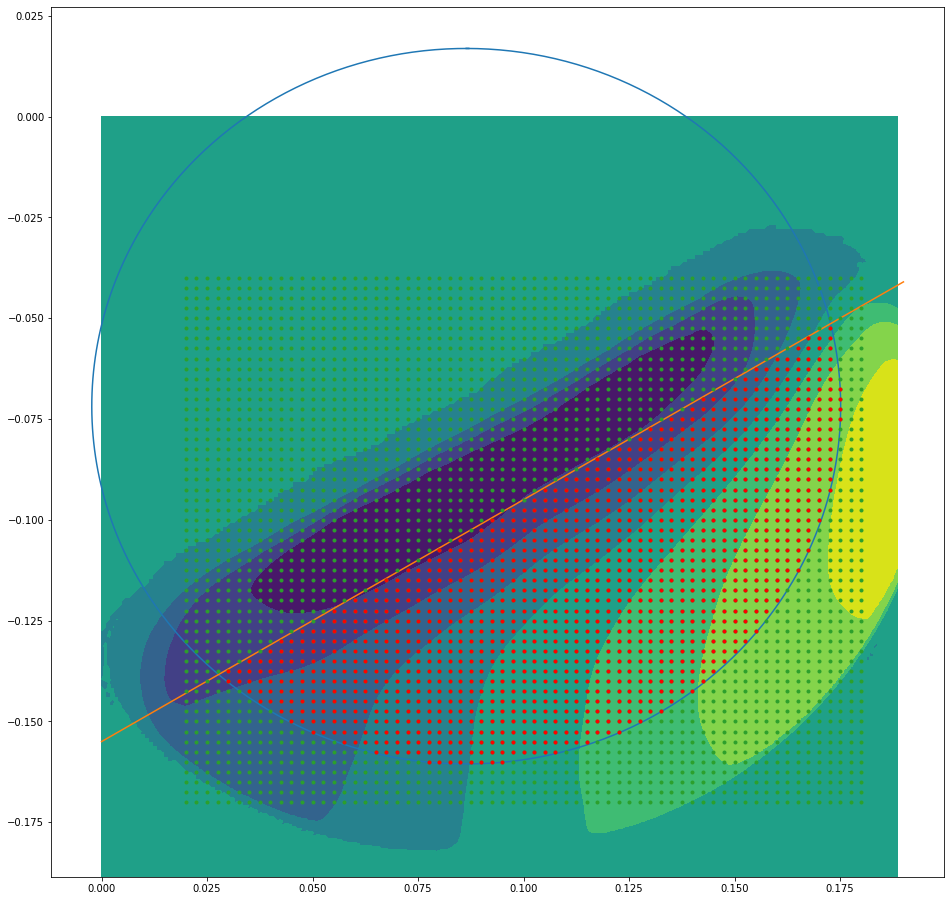

In [102]:
dx = 0.0025
xx,zz = np.meshgrid(np.arange(0.02,0.18+dx,dx),np.arange(-0.17,-0.04+dx,dx))
Xtotal = np.stack((xx.flatten(),zz.flatten()),axis=1)
nx = xx.shape[0]
nz = xx.shape[1]



#removing points outside of circle:
dt = 0.01



pixel2real = 0.0001848337
xc = 467.5*pixel2real
zc = 388.6*pixel2real
#r = 524.8*pixel2real #true radius
r = 480*pixel2real
#r = 400*pixel2real
theta = np.arange(0,2*3.14159+dt,dt)
xcircle = xc + r*np.sin(theta)
zcircle = -zc + r*np.cos(theta)
xline = np.arange(0,0.2,0.01)
m = 0.6
c = -0.155
yline = xline*m + c
X_interior = Xtotal[Xtotal[:,1]-m*Xtotal[:,0]-c<=0,:]
X_interior = X_interior[(X_interior[:,0]-xc)**2 + (X_interior[:,1]+zc)**2 - r**2 <= 0,:]

interior_index0 = np.argwhere(Xtotal[:,1]-m*Xtotal[:,0]-c<=0)
interior_index1 = np.argwhere((Xtotal[:,0]-xc)**2 + (Xtotal[:,1]+zc)**2 - r**2 <= 0) 

interior_index = np.intersect1d(interior_index0,interior_index1)
X_interior = Xtotal[interior_index,:]


plt.figure(figsize=(16,16))
#plt.tricontourf(Xu,Zu,np.sqrt(u_data**2 + v_data**2))
plt.tricontourf(Xu,Zu,v_data)
plt.plot(xcircle,zcircle)
plt.plot(xline,yline)
plt.plot(xx.flatten(),zz.flatten(),'.')
plt.plot(X_interior[:,0],X_interior[:,1],'.',color = 'r')
X = X_interior + 0


In [103]:
#finding nnearest neighbours of each point in Xj
r2 = (X[:,0:1]-X[:,0:1].transpose())**2 + (X[:,1:2]-X[:,1:2].transpose())**2

X_neighbours = np.zeros((X.shape[0],9),dtype = int)

X_neighbours = np.zeros((X.shape[0],9),dtype = int)
for i in range(0,X.shape[0]):
    X_neighbours[i,:] = (np.argpartition(r2[:,i],9)[0:9])


u_interp = LinearNDInterpolator(list(zip(Xu,Zu)), u_data)
v_interp = LinearNDInterpolator(list(zip(Xu,Zu)), v_data)
rho_interp = LinearNDInterpolator(list(zip(Xu,Zu)), rho_data)

u_test = u_interp(Xtotal[:,0:1],Xtotal[:,1:2])
v_test = v_interp(Xtotal[:,0:1],Xtotal[:,1:2])
rho_test = rho_interp(Xtotal[:,0:1],Xtotal[:,1:2])

u_test[np.isnan(u_test)] = 0
v_test[np.isnan(v_test)] = 0
rho_test[np.isnan(rho_test)] = 0

#plt.tricontourf(X_interior[:,0],X_interior[:,1],X_interior[:,0]*m+c-X_interior[:,1])

In [104]:
#calculating velocity derivatives:

recalculate_velocity = False

if recalculate_velocity:
    phi_matu = phi(Xtotal,Xtotal,0)
    dphidx_matu = dphidx(Xtotal,Xtotal,0)
    dphidz_matu = dphidz(Xtotal,Xtotal,0)
    d2phidxdz_matu = d2phidxdz(Xtotal,Xtotal,0)
    d2phidx2_matu = d2phidx2(Xtotal,Xtotal,0)
    d2phidz2_matu = d2phidz2(Xtotal,Xtotal,0)

    #in velocity space:
    phi_invu = np.linalg.inv(phi_matu)
    dphidx_matu = np.matmul(dphidx_matu,phi_invu)
    dphidz_matu = np.matmul(dphidz_matu,phi_invu)
    d2phidx2_matu = np.matmul(d2phidx2_matu,phi_invu)
    d2phidz2_matu = np.matmul(d2phidz2_matu,phi_invu)
    d2phidxdz_matu = np.matmul(d2phidxdz_matu,phi_invu)
    nabla2_matu = d2phidx2_matu + d2phidz2_matu





In [105]:
#smoothing factor
sigma = 0
dsigma = 0
d2sigma = 0

u_test = gaussian_smooth(u_test,nx,nz,sigma)
v_test = gaussian_smooth(v_test,nx,nz,sigma)
rho_test = gaussian_smooth(rho_test,nx,nz,sigma)
omega = 5
u_test = 1 + 0.5*np.sin(omega*Xtotal[:,0:1])
v_test = u_test*0
rho_test = 1/(1 + 0.5*np.sin(omega*Xtotal[:,0:1]))



In [106]:
#finding density to minimize continuity errors
#N = 
cont_eq = np.matmul(dphidx_matu,np.diag(u_test.flatten())) + np.matmul(np.diag(u_test.flatten()),dphidx_matu)*0
cont_eq += np.matmul(dphidz_matu,np.diag(v_test.flatten())) + np.matmul(np.diag(v_test.flatten()),dphidz_matu)*0

measurement_bias = 1
smoothness_bias = 0.001

#we also want to minimize the distance between the measured rho and the predicted rho:
#and smoothness of the density
N = cont_eq.shape[0]
gov_mat = np.zeros((4*N,N))
gov_mat[0:N,:] = cont_eq
gov_mat[N:2*N,:] = np.eye(N)*measurement_bias
gov_mat[2*N:3*N,:] = dphidx_matu*smoothness_bias*dx
gov_mat[3*N:4*N,:] = dphidz_matu*smoothness_bias*dx

gov_vect = np.zeros((4*N,1))
gov_vect[N:2*N,:] = rho_test*measurement_bias
#gov_vect[N:2*N,:] = np.ones((N,1))*measurement_bias
rho = np.linalg.lstsq(gov_mat,gov_vect,rcond=None)




In [107]:


#velocity fields:
u = np.diag(u_test[interior_index,0])
v = np.diag(v_test[interior_index,0])
dudz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[interior_index,0] )
dudztest = gaussian_smooth(np.matmul(dphidz_matu,u_test),nx,nz,dsigma)[:,0]
dudx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,u_test),nx,nz,dsigma)[interior_index,0])
d2udx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,u_test),nx,nz,d2sigma)[interior_index,0])
d2udxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test),nx,nz,d2sigma)[interior_index,0])

dvdz = np.diag(gaussian_smooth(np.matmul(dphidz_matu,v_test),nx,nz,dsigma)[interior_index,0])
dvdx = np.diag(gaussian_smooth(np.matmul(dphidx_matu,v_test),nx,nz,dsigma)[interior_index,0])
d2vdx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,v_test),nx,nz,d2sigma)[interior_index,0])
d2vdxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,v_test),nx,nz,d2sigma)[interior_index,0])



d3udz3 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidz_matu,d2phidz2_matu),u_test),nx,nz,d2sigma)[interior_index,0])
d3vdx3 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidx_matu,d2phidx2_matu),v_test),nx,nz,d2sigma)[interior_index,0])
d3udx2dz = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidz_matu,d2phidx2_matu),u_test),nx,nz,d2sigma)[interior_index,0])
d3vdxdz2 = np.diag(gaussian_smooth(np.matmul(np.matmul(dphidx_matu,d2phidz2_matu),v_test),nx,nz,d2sigma)[interior_index,0])





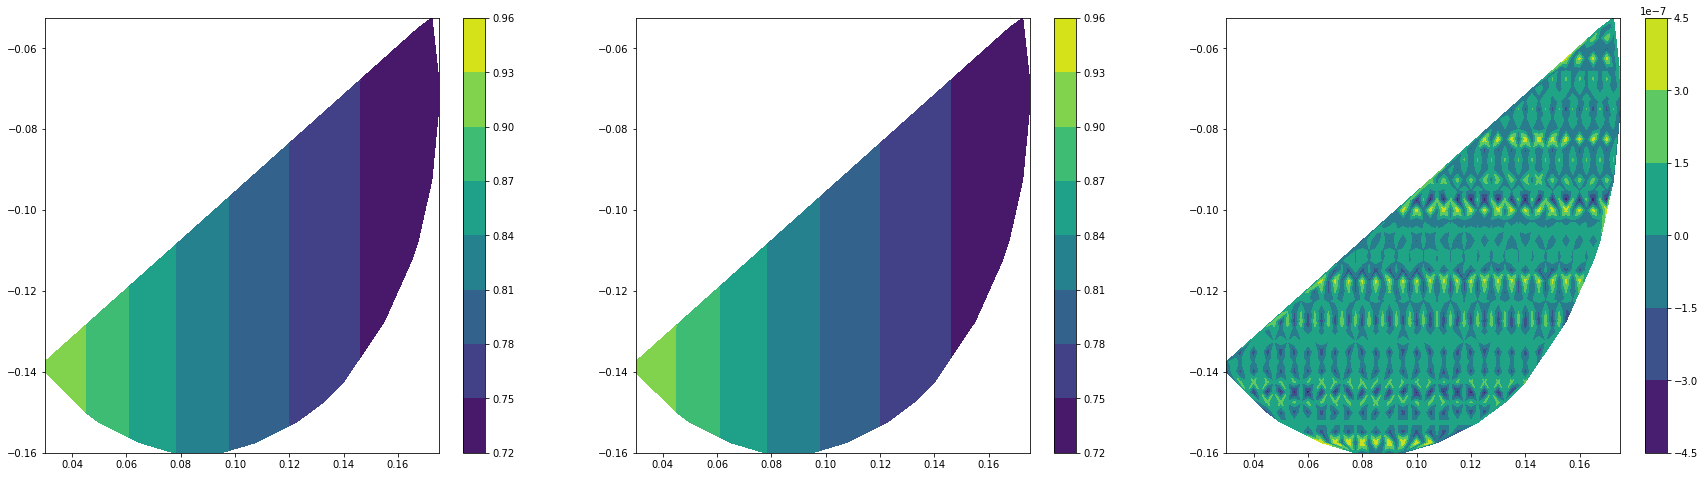

In [108]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],rho_test[interior_index,0])
plt.colorbar()
plt.subplot(1,3,2)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],rho[0][interior_index,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],np.matmul(cont_eq,rho[0])[interior_index,0])
plt.colorbar()

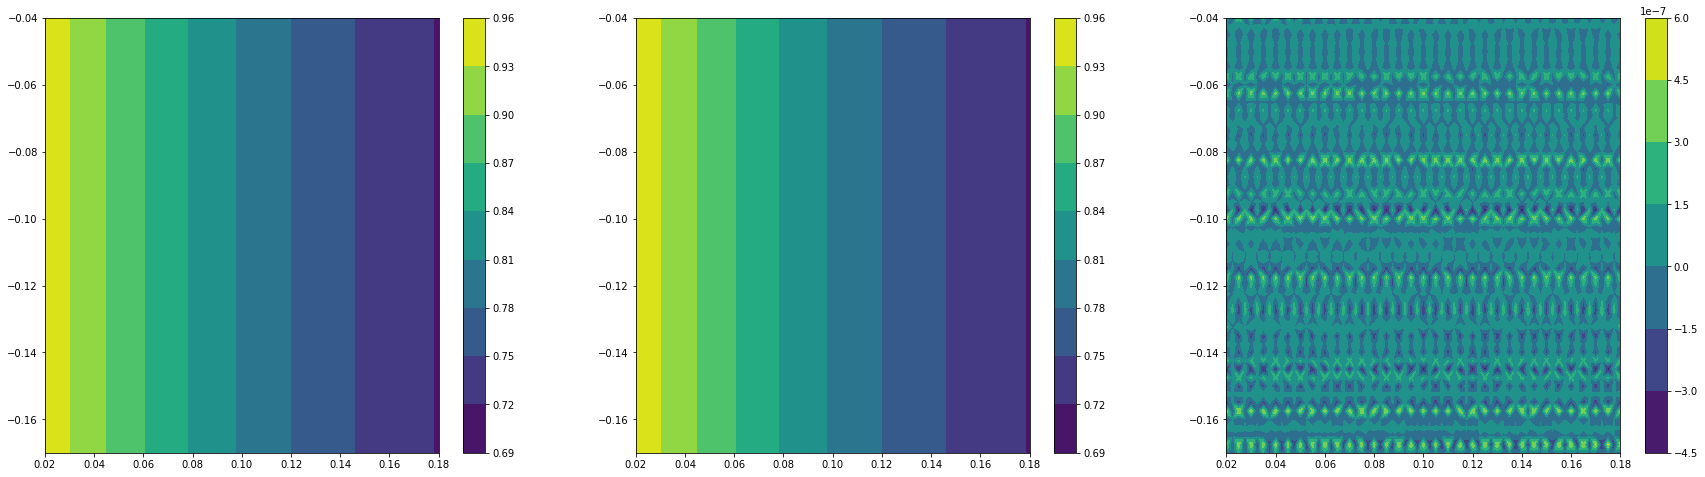

In [109]:
plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],rho_test[:,0])
plt.colorbar()
plt.subplot(1,3,2)
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],rho[0][:,0])
plt.colorbar()
plt.subplot(1,3,3)
plt.tricontourf(Xtotal[:,0],Xtotal[:,1],np.matmul(cont_eq,rho[0])[:,0])
plt.colorbar()
rho = rho[0]

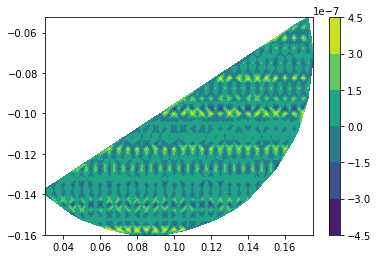

In [110]:
dpudx = np.matmul(dphidx_matu,rho*u_test)
dpvdz = np.matmul(dphidz_matu,rho*v_test)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],(dpudx+0*dpvdz)[interior_index,0])
#plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],(rho_test*u_test)[interior_index,0])
plt.colorbar()

In [111]:
d2puudxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test*u_test*rho_test),nx,nz,d2sigma)[:,0] )
d2puvdz2 = np.diag(gaussian_smooth(np.matmul(d2phidz2_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )
d2puvdx2 = np.diag(gaussian_smooth(np.matmul(d2phidx2_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )
d2pvvdxdz = np.diag(gaussian_smooth(np.matmul(d2phidxdz_matu,u_test*v_test*rho_test),nx,nz,d2sigma)[:,0] )

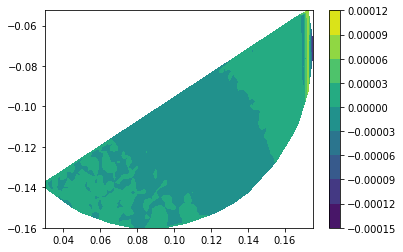

In [112]:
#checking continuity:

dpudx = np.matmul(dphidx_matu,rho_test*u_test)
dpvdz = np.matmul(dphidz_matu,rho_test*v_test)
plt.tricontourf(Xtotal[interior_index,0],Xtotal[interior_index,1],(dpudx+dpvdz)[interior_index,0])
plt.colorbar()
#plt.plot(np.abs((dpudx+dpvdz)[:,0]),'.')
#plt.yscale('log')

The navier-stokes vorticity equation is given by
$ \frac{\partial^2 \rho u^2}{\partial x \partial z} + \frac{\partial^2 \rho u v}{\partial z^2} - \frac{\partial \rho u v}{\partial x^2} - \frac{\partial^2 \rho v^2}{\partial x \partial z}$